### Define Data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv("data_train.csv", index_col=0)

In [2]:
#Overview of the top 'n' genres and the proportion of songs within each cluster of the training df
n = 5

song_count = len(df)
genre_dict = {cluster: list(df['track_genre'][df['cluster'] == cluster].value_counts().index[:n]) for cluster in df['cluster'].unique()}
cluster_df = pd.DataFrame({"cluster":df['cluster'], "genre": df['track_genre']})
count_dict_unformatted = cluster_df['cluster'].value_counts().to_dict()
count_dict = pd.DataFrame({k: [f"{v/song_count*100:.0f}%"] for k,v in count_dict_unformatted.items()})

summary_df = pd.concat([pd.DataFrame(genre_dict), pd.DataFrame(count_dict)], ignore_index = True)
summary_df.rename({i: i+1 for i in range(len(summary_df))}).rename({len(summary_df): "Percent of Data"})

,1,2,4,0,7,3,5,6
1,tango,kids,comedy,pagode,k-pop,metalcore,new-age,minimal-techno
2,romance,latin,show-tunes,samba,pop-film,heavy-metal,classical,detroit-techno
3,honky-tonk,party,funk,sertanejo,forro,death-metal,sleep,techno
4,cantopop,salsa,kids,mpb,deep-house,hardstyle,ambient,chicago-house
5,jazz,reggae,children,gospel,turkish,grunge,piano,trance
Percent of Data,18%,19%,1%,6%,21%,18%,6%,10%


In [117]:
#Example for binary cluster classification
selected_cluster = 3


#Coerce boolean to binary
df[f'cluster{selected_cluster}_binary'] = (df['cluster'] == selected_cluster) *1
df =df.astype({'mode':'bool', 'time_signature' : 'category', 'key' : 'category'})
#Drop columns (should we drop track_genre??) and create training/testing 
#NOTE a testing csv has already been witheld
X_train = df.drop(labels = ['track_genre', 'cluster'], axis=1)
y_train = X_train.pop(f'cluster{selected_cluster}_binary')


## AdaBoost Decision Tree
### Optimize parameters through Grid Search SV

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

parameters = {"estimator__criterion" : ["entropy", "gini"],
              'estimator__max_depth': [1,3,5],
              'n_estimators':[100, 200, 300], 
              'learning_rate':[0.2, 0.5, 0.8]}


abc_clf = AdaBoostClassifier(DecisionTreeClassifier())
gs_clf = GridSearchCV(abc_clf, parameters, cv = 3)
gs_clf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier()),
             param_grid={'estimator__criterion': ['entropy', 'gini'],
                         'estimator__max_depth': [1, 3, 5],
                         'learning_rate': [0.2, 0.5, 0.8],
                         'n_estimators': [100, 200, 300]})

In [77]:
#pd.DataFrame(gs_clf.cv_results_)

In [14]:
gs_clf.best_params_

{'estimator__criterion': 'gini',
 'estimator__max_depth': 3,
 'learning_rate': 0.5,
 'n_estimators': 300}

### Fit model with full training set

In [119]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

abc_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3, criterion='gini'), n_estimators=300, learning_rate=0.5)
abc_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.5, n_estimators=300)

### Read in Testing CSV and format. Caluclate testing accuracy.

In [118]:
df_test = pd.read_csv("data_test.csv", index_col=0)

#Example for binary cluster classification
selected_cluster = 3

#Coerce boolean to binary
df_test[f'cluster{selected_cluster}_binary'] = (df_test['cluster'] == selected_cluster) *1
df_test =df_test.astype({'mode':'bool', 'time_signature' : 'category', 'key' : 'category'})
#Drop columns (should we drop track_genre??) and create training/testing 

X_test = df_test.drop(labels = ['track_genre', 'cluster'], axis=1)
y_test = X_test.pop(f'cluster{selected_cluster}_binary')


In [120]:
#Testing Accuracy

yhat = abc_clf.predict(X_test)
(yhat == y_test).mean()

0.9909649122807017

### Create ROC Curves and calculate AOC for training and testing.

In [121]:
from sklearn import metrics

yhat_test_probs = abc_clf.predict_proba(X_test)
yhat_test_probs = yhat_test_probs[:,1]

fpr_test, tpr_test, thresholds = metrics.roc_curve(y_test, yhat_test_probs, pos_label=1)
auc_test = metrics.auc(fpr_test, tpr_test)

yhat_train_probs = abc_clf.predict_proba(X_train)
yhat_train_probs = yhat_train_probs[:,1]

fpr_train, tpr_train, thresholds = metrics.roc_curve(y_train, yhat_train_probs, pos_label=1)
auc_train = metrics.auc(fpr_train, tpr_train)

print(auc_train)
print(auc_test)

0.999996470983117
0.9989404901366317


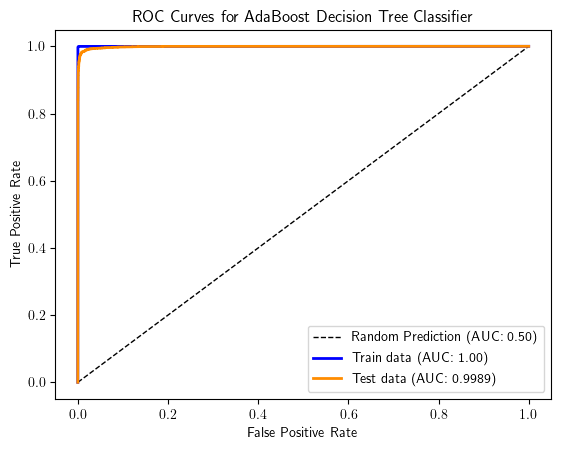

In [122]:

import matplotlib.pyplot as plt
plt.title('ROC Curves for AdaBoost Decision Tree Classifier')
plt.plot([0, 1], [0, 1],'k--', label = "Random Prediction (AUC: 0.50)", linewidth = 1)
plt.plot(fpr_train, tpr_train, color = 'blue', label = f"Train data (AUC: {auc_train:.2f})", linewidth = 2)
plt.plot(fpr_test, tpr_test, color = 'darkorange', label = f"Test data (AUC: {auc_test:.4f})", linewidth = 2)
plt.legend(loc = 'lower right')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Discussion

### Create pairwise decision boundary plots

In [123]:
#Fit model and predict. Necessary to order data by y_predicted in next step
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3,  criterion = 'gini'), n_estimators = 300, learning_rate = 0.5).fit(X_train,y_train)
y_predicted = model.predict(X_train)

In [124]:
#Sort data such that target values appear on top of scatter
df_ordered = pd.DataFrame(X_train)
df_ordered['y']= y_predicted
df_ordered.sort_values(by = 'y', inplace = True)
y_sorted_df = df_ordered.pop('y')
X_sorted_df = df_ordered

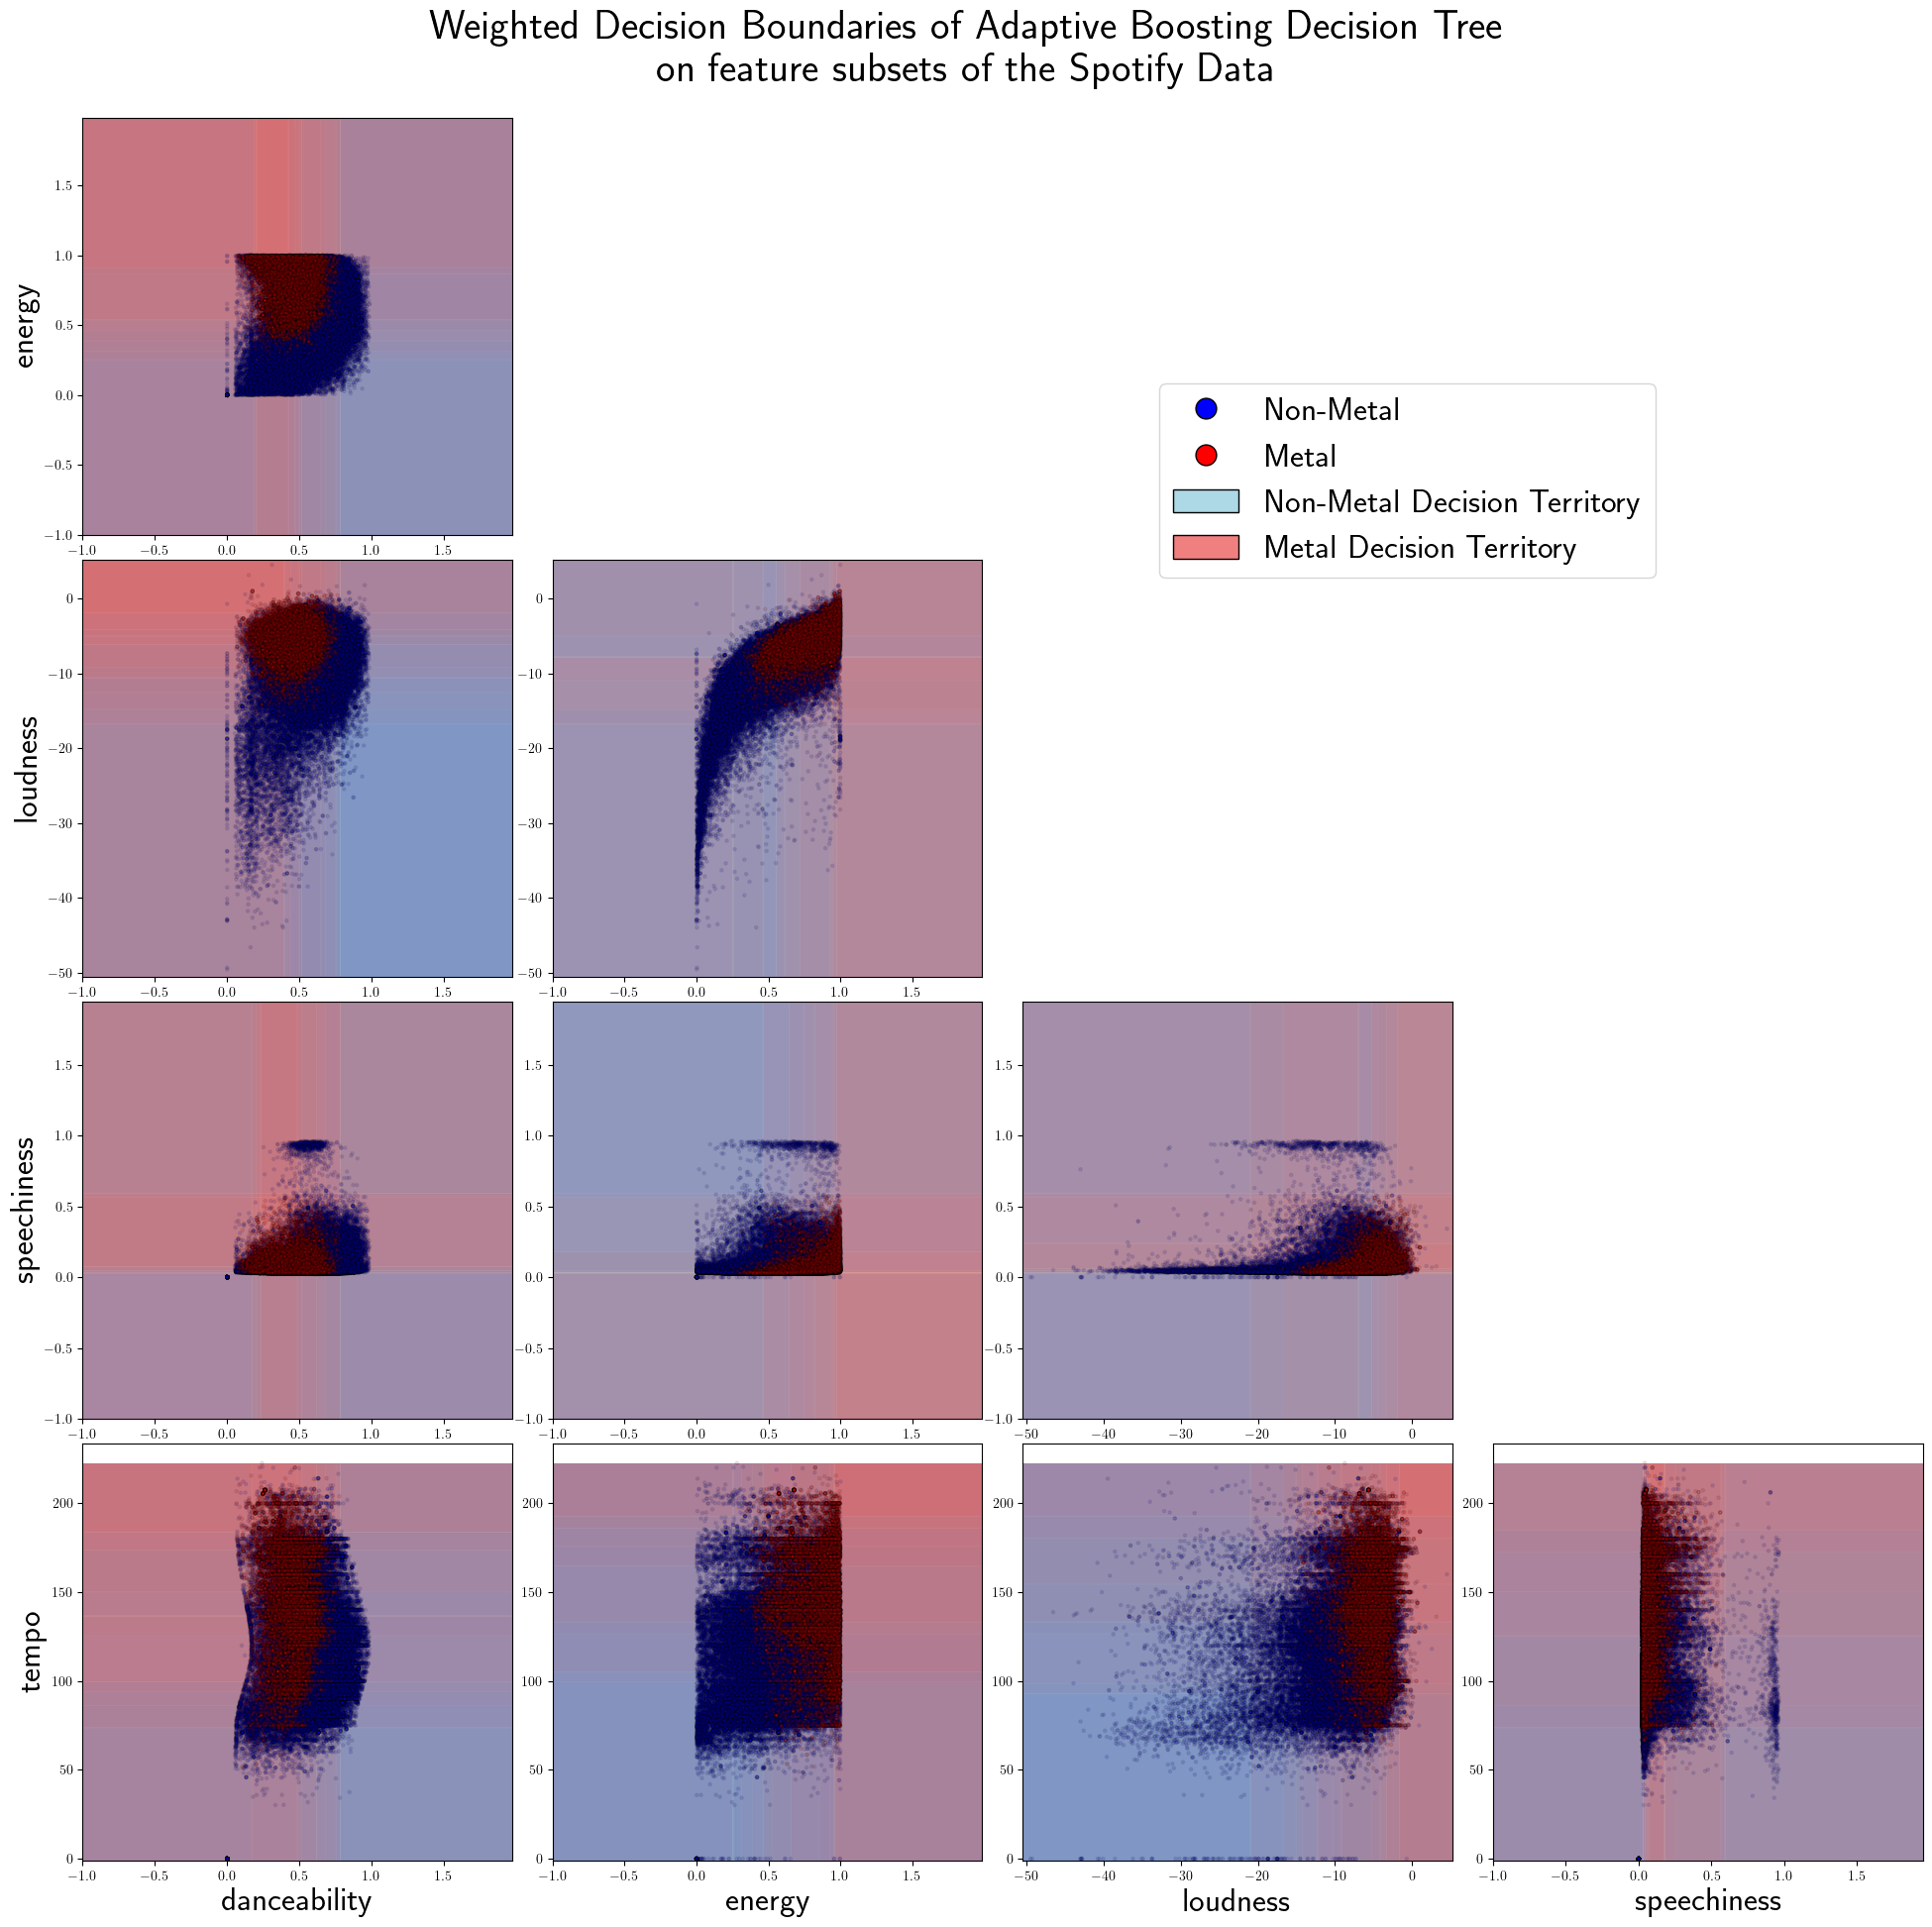

In [132]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

sample = X_sorted_df.iloc[:,[3,4,6,8,13]]

# Colours
cmap = plt.cm.RdYlBu
cmap = cmap.reversed()

#ADJUST MODEL PARAMTERS TO ACCOUNT FOR 2 VARIABLES (PAIRWISE) INSTEAD OF FULL COMPLIMENT
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1,  criterion = 'gini'), 
                           n_estimators = int(300/(len(X_train.columns))), 
                           learning_rate = 0.5*(1+(1/(len(X_train.columns))))).fit(X_train,y_train)

n = len(sample.columns) #number of features

fig, axs = plt.subplots(n-1, n-1, figsize=(20, 20))

pairs = [(a, b) for idx, b in enumerate(np.arange(n)) for a in np.arange(n)[idx + 1:]]
for pair in pairs:
        X_i = sample.to_numpy()[:,pair]
        y_i = y_sorted_df.to_numpy()

        model.fit(X_i, y_i)

        model_title = str(type(model)).split(".")[-1][:-2][: -len("Classifier")]

        x_min, x_max = X_i[:, 0].min() - 1, X_i[:, 0].max() + 1
        y_min, y_max = X_i[:, 1].min() - 1, X_i[:, 1].max() + 1
        xx, yy = np.meshgrid(
            np.arange(x_min, x_max, (x_max-x_min)/200), np.arange(y_min, y_max, (y_max-y_min)/200)
        )
        estimator_alpha = 1 / len(model.estimators_)
        for tree in model.estimators_:
            Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = axs[pair[0]-1,pair[1]].contourf(yy, xx, Z, alpha=estimator_alpha, cmap=cmap) 

        axs[pair[0]-1,pair[1]].scatter(
            X_i[:, 1],    
            X_i[:, 0],    
            c=y_i,
            cmap=ListedColormap(["b", "r"]),
            edgecolor="k",
            s=5,
            alpha = 0.1
        )


for pair in pairs[1:len(pairs)-1]:
    if pair[1] != pair[0]-1:
        fig.delaxes(axs[pair[1],pair[0]-1])


cols = list(sample.columns[0:n-1])
rows = list(sample.columns[1:n])



for ax, col in zip(axs[3], cols):
    ax.set_xlabel(col, fontsize=24)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=24)

plt.suptitle("Weighted Decision Boundaries of Adaptive Boosting Decision Tree \n on feature subsets of the Spotify Data", fontsize=30)
plt.axis("tight")
plt.tight_layout(h_pad=0.2, w_pad=0.2, pad=2.5)

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [Line2D([0], [0], marker='o', lw = 0, color='k', label='Non-Metal',
                          markerfacecolor='b',  markersize=15),
                    Line2D([0], [0], marker='o', lw = 0, color='k', label='Metal',
                          markerfacecolor='r', markersize=15),
                   Patch(facecolor='lightblue', edgecolor='k',
                         label='Non-Metal Decision Territory'),
                   Patch(facecolor='lightcoral', edgecolor='k',
                         label='Metal Decision Territory')]

plt.figlegend(handles=legend_elements, loc=(0.6, 0.7), fontsize="24")


plt.show()

### Create tSNE Decision Boundary Plot

In [76]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


#Scale data for knn
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_sc= scaler.transform(X_train)

X_Train_embedded = TSNE(n_components=2).fit_transform(X_train_sc)
print (X_Train_embedded.shape)


(91200, 2)


In [133]:
#Fit model and predict. Necessary to order data by y_predicted in next step
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3,  criterion = 'gini'), n_estimators = 300, learning_rate = 0.5).fit(X,y)
y_predicted = model.predict(X)

#SORTED VALUES SUCH THAT TRAGET =1 IS ON TOP OF SCATTER
from matplotlib.colors import ListedColormap

df_ordered = pd.DataFrame(X_Train_embedded)
df_ordered['y']= y_predicted
df_ordered.sort_values(by = 'y', inplace = True)
y_sorted = df_ordered.pop('y').to_numpy()
X_emb_sorted = df_ordered.to_numpy()

In [135]:

# create meshgrid
resolution = 1000 # 1000x1000 background pixels
X2d_xmin, X2d_xmax = np.min(X_emb_sorted[:,0]), np.max(X_emb_sorted[:,0])
X2d_ymin, X2d_ymax = np.min(X_emb_sorted[:,1]), np.max(X_emb_sorted[:,1])

xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

# approximate Voronoi tesselation on resolution x resolution grid using 1-NN
background_model = KNeighborsClassifier(n_neighbors=1).fit(X_emb_sorted, y_sorted) 
voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
voronoiBackground = voronoiBackground.reshape((resolution, resolution))

#plot

cmap = plt.cm.RdYlBu
cmap = cmap.reversed()

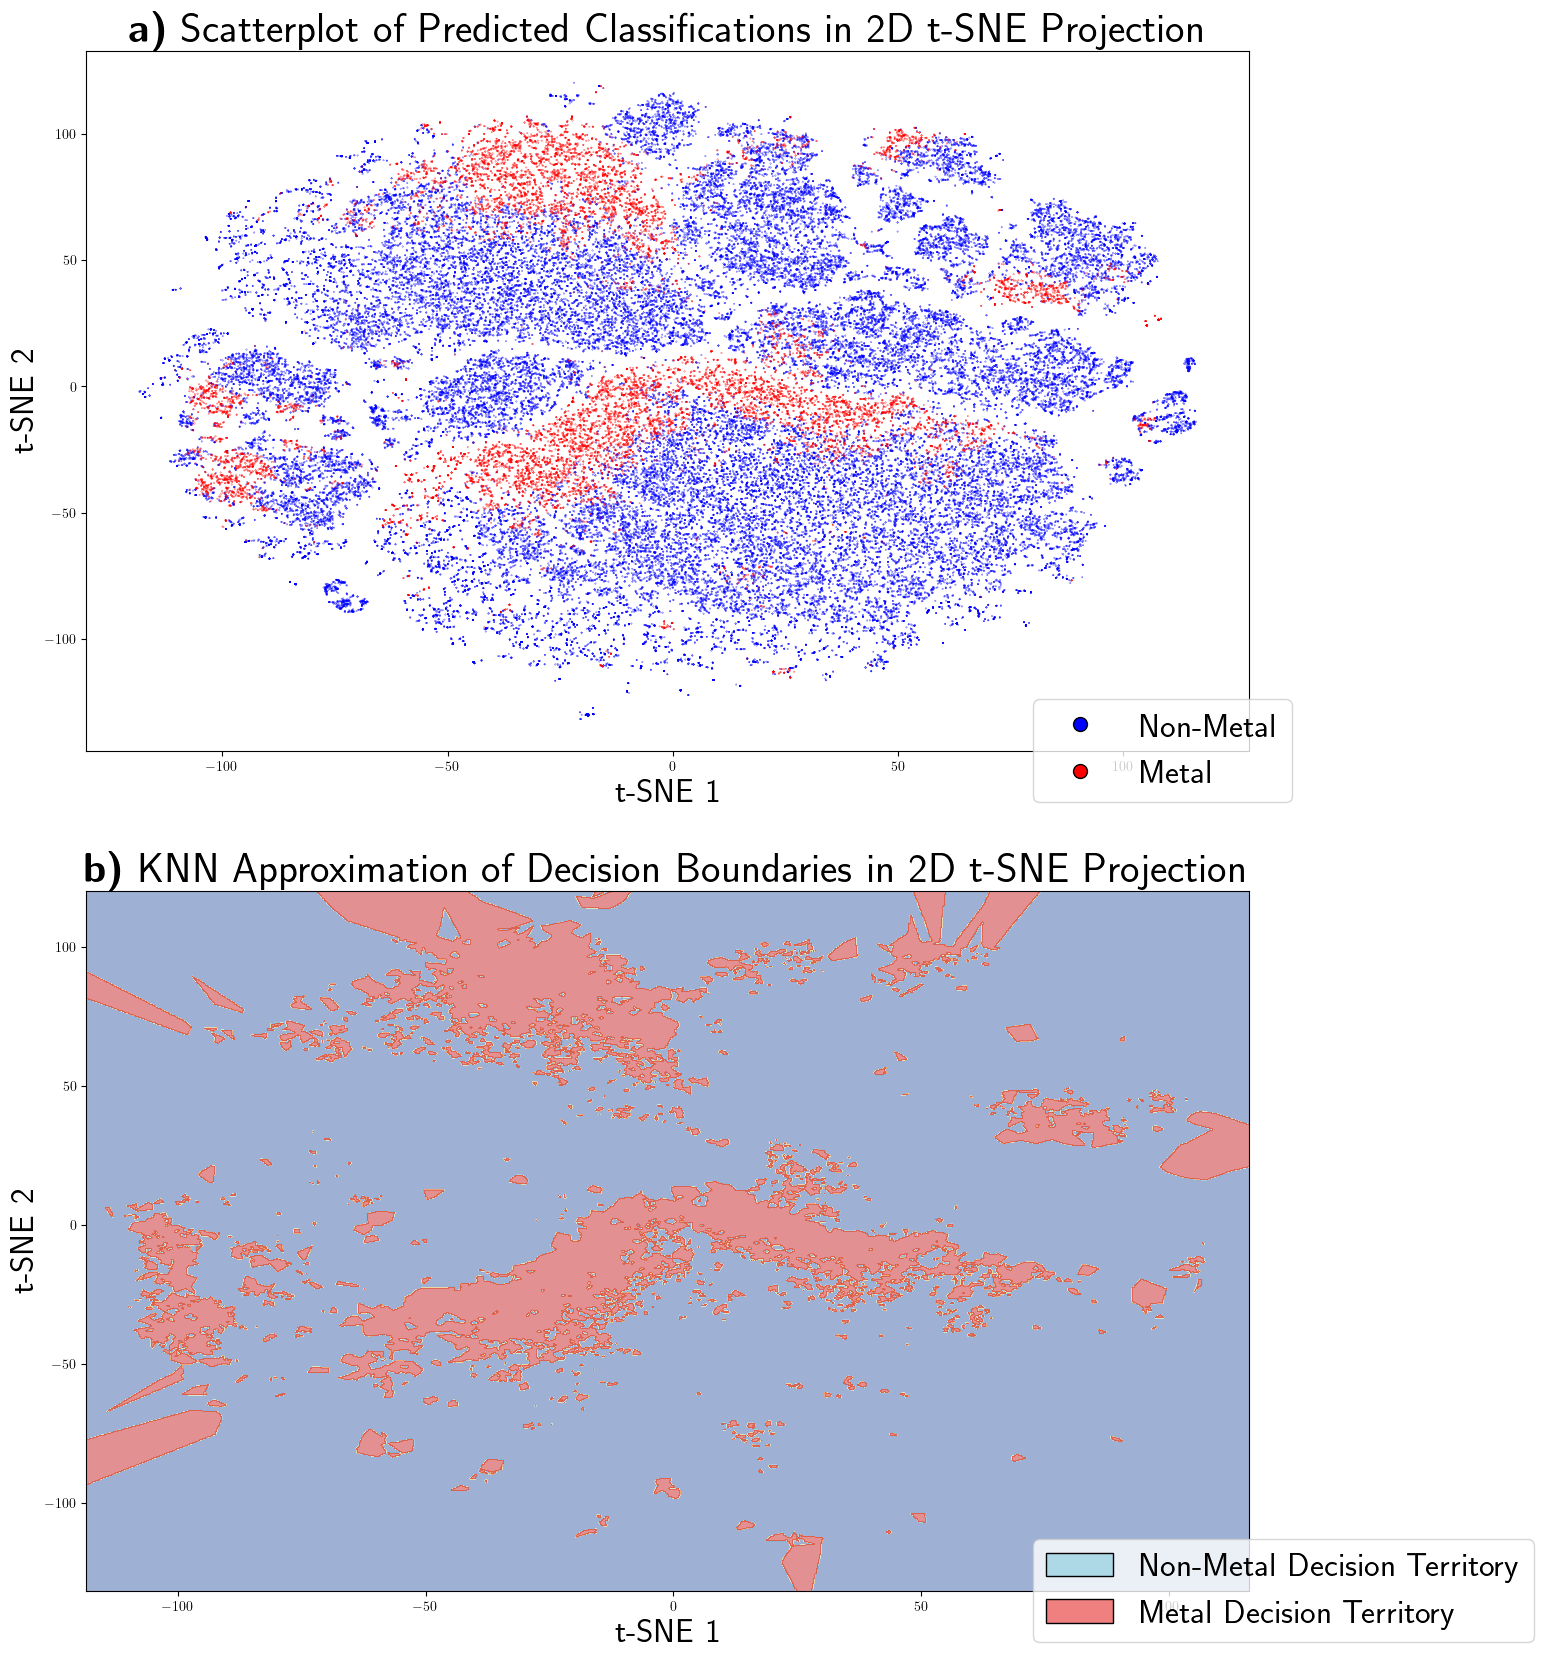

In [136]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

fig = plt.figure(figsize=(15, 20))

plt.subplot(2, 1, 2)

plt.contourf(xx, yy, voronoiBackground, cmap = cmap, alpha = 0.5)
plt.xlabel("t-SNE 1",fontsize=24)
plt.ylabel("t-SNE 2",fontsize=24)
plt.rc('text', usetex=True)
plt.title(r"\textbf{b)} KNN Approximation of Decision Boundaries in 2D t-SNE Projection", fontsize=30)
legend_elements = [Patch(facecolor='lightblue', edgecolor='k',
                         label='Non-Metal Decision Territory'),
                   Patch(facecolor='lightcoral', edgecolor='k',
                         label='Metal Decision Territory')]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.8, 0), fontsize="24")


plt.subplot(2, 1, 1)
plt.scatter(X_emb_sorted[:,0], X_emb_sorted[:,1], c = y_sorted,cmap=ListedColormap(["b", "r"]), s = 0.05)
plt.xlabel("t-SNE 1",fontsize=24)
plt.ylabel("t-SNE 2",fontsize=24)
plt.rc('text', usetex=True)
plt.title(r"\textbf{a)} Scatterplot of Predicted Classifications in 2D t-SNE Projection", fontsize=30)



legend_elements = [Line2D([0], [0], marker='o', lw = 0, color='k', label='Non-Metal',
                          markerfacecolor='b',  markersize=10),
                    Line2D([0], [0], marker='o', lw = 0, color='k', label='Metal',
                          markerfacecolor='r', markersize=10)]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.8, 0), fontsize="24")
